# Keras 로 MF 구현


In [64]:
import pandas as pd

from sklearn.model_selection import train_test_split

import os
import tensorflow as tf
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras.optimizer_v1 import SGD, Adamax



base_src = '../data/drive-download-20240102T142504Z-001'
u_data_src = os.path.join(base_src, 'u.data')
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(
    u_data_src,
    sep='\t',
    names=r_cols,
    encoding='latin-1'
)

rating_train, rating_test = train_test_split(ratings, test_size=0.2, shuffle=True, random_state=2021)

In [65]:
tf.compat.v1.disable_eager_execution()

K = 200

mu = rating_train.rating.mean()

M = rating_train.user_id.max() + 1
N = rating_train.movie_id.max() + 1


def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [66]:
user = Input(shape=(1,))
item = Input(shape=(1,))

P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)

user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)

In [67]:
R = layers.dot([P_embedding, Q_embedding], axes=(2, 2))
R = layers.add([R, user_bias, item_bias])
R = Flatten()(R)
model = Model(inputs=[user, item], outputs=R)
model.compile(
    loss=RMSE,
    optimizer=SGD(),
    metrics=[RMSE]
)

model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_56 (Embedding)        (None, 1, 200)       188800      input_3[0][0]                    
__________________________________________________________________________________________________
embedding_57 (Embedding)        (None, 1, 200)       336600      input_4[0][0]                    
___________________________________________________________________________________________

In [68]:
result = model.fit(
    x=[rating_train.user_id.values,
       rating_train.movie_id.values],
    y=rating_train.rating.values - mu,
    epochs=60,
    batch_size=256,
    validation_data=(
        [rating_test.user_id.values,
         rating_test.movie_id.values],
        rating_test.rating.values - mu
    )
)

Train on 80000 samples, validate on 20000 samples
Epoch 1/60
16640/80000 [=====>........................] - ETA: 0s - loss: 5.4633 - RMSE: 1.1221

2024-01-13 02:00:48.592061: W tensorflow/c/c_api.cc:305] Operation '{name:'embedding_56/embeddings/Assign' id:497 op device:{requested: '', assigned: ''} def:{{{node embedding_56/embeddings/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](embedding_56/embeddings, embedding_56/embeddings/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


80000/80000 [==============================] - 1s 8us/sample - loss: 5.2603 - RMSE: 1.1262 - val_loss: 4.9966 - val_RMSE: 1.1199
Epoch 2/60
11776/80000 [===>..........................] - ETA: 0s - loss: 4.9655 - RMSE: 1.1207

/Users/jaypark/anaconda3/lib/python3.11/site-packages/tensorflow/python/keras/engine/training.py:2455: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2024-01-13 02:00:49.234510: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_1/AddN_1' id:674 op device:{requested: '', assigned: ''} def:{{{node loss_1/AddN_1}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul, loss_1/AddN)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


80000/80000 [==============================] - 1s 9us/sample - loss: 4.7716 - RMSE: 1.1241 - val_loss: 4.5385 - val_RMSE: 1.1148
Epoch 3/60
80000/80000 [==============================] - 1s 9us/sample - loss: 4.3406 - RMSE: 1.1222 - val_loss: 4.1337 - val_RMSE: 1.1113
Epoch 4/60
80000/80000 [==============================] - 1s 8us/sample - loss: 3.9602 - RMSE: 1.1202 - val_loss: 3.7770 - val_RMSE: 1.1138
Epoch 5/60
80000/80000 [==============================] - 1s 8us/sample - loss: 3.6246 - RMSE: 1.1186 - val_loss: 3.4622 - val_RMSE: 1.1101
Epoch 6/60
80000/80000 [==============================] - 1s 8us/sample - loss: 3.3287 - RMSE: 1.1171 - val_loss: 3.1844 - val_RMSE: 1.1105
Epoch 7/60
80000/80000 [==============================] - 1s 8us/sample - loss: 3.0675 - RMSE: 1.1158 - val_loss: 2.9391 - val_RMSE: 1.1087
Epoch 8/60
80000/80000 [==============================] - 1s 9us/sample - loss: 2.8370 - RMSE: 1.1142 - val_loss: 2.7230 - val_RMSE: 1.1042
Epoch 9/60
80000/80000 [=======

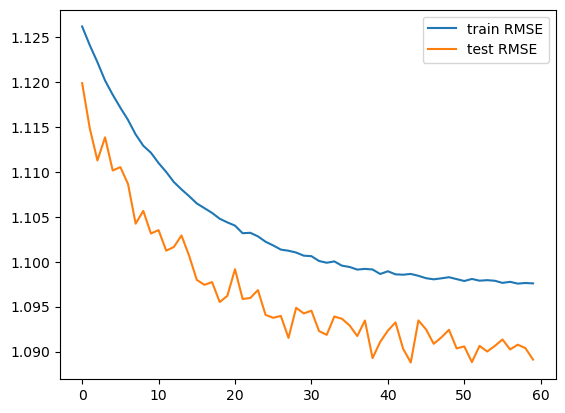

In [69]:
import matplotlib.pyplot as plt

plt.plot(result.history['RMSE'], label='train RMSE')
plt.plot(result.history['val_RMSE'], label='test RMSE')
plt.legend()
plt.show()

In [70]:
user_ids = rating_train.user_id.values[0:6]
movie_ids = rating_train.movie_id.values[0:6]

predictions = model.predict([user_ids, movie_ids]) + mu

/Users/jaypark/anaconda3/lib/python3.11/site-packages/tensorflow/python/keras/engine/training.py:2455: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2024-01-13 02:01:31.169420: W tensorflow/c/c_api.cc:305] Operation '{name:'flatten_14/Reshape' id:551 op device:{requested: '', assigned: ''} def:{{{node flatten_14/Reshape}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _has_manual_control_dependencies=true](add_14/add_1, flatten_14/Const)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [71]:
print(rating_test[0:6])

       user_id  movie_id  rating  timestamp
23307      468        51       3  875293386
36679       92       780       3  875660494
36626      555       489       5  879975455
83753      940        69       2  885921265
52604      181      1350       1  878962120
49877      320       195       5  884749255


In [72]:
print(predictions)

[[3.446763 ]
 [3.6278915]
 [3.5256078]
 [3.5814226]
 [3.5384753]
 [3.5379558]]


In [73]:
import numpy as np

def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred)) ** 2))

In [74]:
user_ids = rating_test.user_id.values
movie_ids = rating_test.movie_id.values

y_pred = model.predict([user_ids, movie_ids]) + mu
y_pred = np.ravel(y_pred,order='C')
y_true = np.array(rating_test.rating)

RMSE2(y_true, y_pred)

1.0913900720861789